# **Preliminaries:** Install and import modules

In [1]:
#@title [RUN] install
!pip install networkx
!pip install mycolorpy
!pip install colorama
!pip install ogb

import torch
import os
!pip install torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3874 sha256=df0e120cfdb6aefba1c6835cebb6c9e52913fcdf7bb3634c580e3dd8b53edb5d
  Stored in directory: /root/.cache/pip/wheels/b9/56/d6/a163bcbec3bb69f3f7797b1b542870b18d7e31ff5dbc0b87e3
Successfully built mycolorpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=d90bd2588d1c2e7d33f2dcc4a63de781546b67e5965ffd036994470c5

In [2]:
#@title [RUN] Import modules
import numpy as np
import seaborn as sns
import math
import itertools
import scipy as sp
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import Planetoid, Coauthor
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils import to_dense_adj
from torch.nn import Embedding
from torch_geometric.typing import Adj
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.loader import NeighborLoader


import pdb
from datetime import datetime

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

from mycolorpy import colorlist as mcp
import matplotlib.cm as cm

from typing import Mapping, Tuple, Sequence, List
import colorama

import scipy.linalg
from scipy.linalg import block_diag

In [3]:
####### PLOTS #######

def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats

def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))

def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)
    
    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))

# Cora dataset



In [4]:
cora_dataset = Planetoid("/tmp/cora", name="cora", split="full")
cora_data = cora_dataset[0]
cora_data

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [5]:
print("Training class sizes")
print(torch.bincount(cora_dataset[0].y[cora_dataset[0].train_mask]))
print("Validation class sizes")
print(torch.bincount(cora_dataset[0].y[cora_dataset[0].val_mask]))
print("Test class sizes")
print(torch.bincount(cora_dataset[0].y[cora_dataset[0].test_mask]))

Training class sizes
tensor([160,  90, 196, 341, 196, 138,  87])
Validation class sizes
tensor([ 61,  36,  78, 158,  81,  57,  29])
Test class sizes
tensor([130,  91, 144, 319, 149, 103,  64])


# OBGN-ARVIX dataset

In [ ]:
d_name = "ogbn-arxiv"

dataset = PygNodePropPredDataset(name = d_name)

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
arxiv_data = dataset[0]
arxiv_data.y = arxiv_data.y.squeeze()
arxiv_data.node_year = arxiv_data.node_year.squeeze()
arxiv_data

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:08<00:00, 10.03it/s]


Extracting dataset/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 10407.70it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 4539.29it/s]

Saving...



Done!


Data(num_nodes=169343, edge_index=[2, 1166243], x=[169343, 128], node_year=[169343], y=[169343])

In [ ]:
print("Training class sizes")
print(torch.bincount(arxiv_data.y[train_idx]))
print("Validation class sizes")
print(torch.bincount(arxiv_data.y[valid_idx]))
print("Test class sizes")
print(torch.bincount(arxiv_data.y[test_idx]))

Training class sizes
tensor([  437,   382,  3604,  1014,  2864,  2933,   703,   380,  4056,  2245,
         5182,   391,    21,  1290,   473,   248,  9998,   202,   402,  1873,
         1495,   304,  1268,  1539,  6989,   457,  2854,  1661, 16284,   239,
         4334,  1350,   270,   926,  5426,    75,  2506,  1615,  1100,  1551])
Validation class sizes
tensor([  74,  118,  502,  412, 1129,  779,  293,   75,  926,  230, 1232,  120,
           3,  440,   53,   68, 6846,  110,  138,  585,  268,   38,  249,  487,
        4458,  325,  710, 1074, 2273,   57, 2849,  586,   58,  125, 1027,   16,
         391,  273,  193,  209])
Test class sizes
tensor([   54,   187,   733,   654,  1869,  1246,   622,   134,  1250,   345,
         1455,   239,     5,   628,    71,    87, 10477,   203,   209,   419,
          313,    51,   386,   808, 10740,   475,  1041,  2066,  2849,   120,
         4631,   892,    83,   220,  1414,    36,   627,   481,   214,   269])


#Coauthor dataset

In [ ]:
cs_dataset = Coauthor("/tmp/coauthor", name="CS")
cs_data = cs_dataset[0]
cs_data

Processing...
Done!


Data(x=[18333, 6805], edge_index=[2, 163788], y=[18333])

In [ ]:
# Create manual split, do 60:20:20 across classes
num_classes_cs = 15
train_mask_cs_indices = []
val_mask_cs_indices = []
test_mask_cs_indices = []
cs_labels = cs_data.y
for i in range(num_classes_cs):

  class_i = np.where(cs_labels == i)[0]
  np.random.seed(0)
  np.random.shuffle(class_i)

  num_samples = len(class_i)
  train_mask_cs_indices += (class_i[:int(num_samples*0.6)]).tolist() 
  val_mask_cs_indices += (class_i[int(num_samples*0.6):int(num_samples*0.8)]).tolist() 
  test_mask_cs_indices += (class_i[int(num_samples*0.8):]).tolist() 

print(len(train_mask_cs_indices), len(val_mask_cs_indices), len(test_mask_cs_indices))
# Create the masks for training
# Test mask 
train_mask_cs = torch.full((len(cs_labels),), False)
train_mask_cs[train_mask_cs_indices] = True
# Val mask
val_mask_cs = torch.full((len(cs_labels),), False)
val_mask_cs[val_mask_cs_indices] = True
# Train mask
test_mask_cs = torch.full((len(cs_labels),), False)
test_mask_cs[test_mask_cs_indices] = True

10993 3668 3672


In [ ]:
print("Training class sizes")
print(torch.bincount(cs_data.y[train_mask_cs]))
print("Validation class sizes")
print(torch.bincount(cs_data.y[val_mask_cs]))
print("Test class sizes")
print(torch.bincount(cs_data.y[test_mask_cs]))

Training class sizes
tensor([ 424,  277, 1230,  257,  836, 1315,  222,  554,  465,   70,  866, 1219,
         252, 2481,  525])
Validation class sizes
tensor([142,  92, 410,  86, 279, 439,  74, 185, 155,  24, 289, 407,  84, 827,
        175])
Test class sizes
tensor([142,  93, 410,  86, 279, 439,  75, 185, 155,  24, 289, 407,  84, 828,
        176])


# Data saving / loading

In [6]:
# use google drive for saving and loading information
from google.colab import drive
import pickle
import os

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/L45_project/'
# create folder if it does not exist already
if not os.path.exists(file_path):
  os.mkdir(file_path) 

Mounted at /content/drive


In [7]:
def save_training_info(training_stats: dict, node_embedding: torch.Tensor, filename: str):
  # write training data info to a file
  with open(file_path + filename + ".pkl", 'wb') as fp:
    pickle.dump(training_stats, fp)
    print('Training stats saved successfully to file: ' + filename)
  # write node embedding to a file
  torch.save(node_embedding, file_path + filename + "_emb.pt")
  print('Node embedding saved successfully to file: ' + filename)


def load_training_info(filename: str):
  # load training stats dictionary 
  with open(file_path + filename + ".pkl", 'rb') as fp:
    train_stats = pickle.load(fp)
    print('Training stats successfully loaded from file: ' + filename)
  # load node embedding
  node_embedding = torch.load(file_path + filename + "_emb.pt")
  print('Node embedding successfully loaded from file: ' + filename)
  return train_stats, node_embedding

# Final results is a list [seed, test result, [test per class accuracy], [training per class accuracy], [val per class accuracy]]
def save_final_results(final_results: List, filename: str):
  # write training data info to a file
  with open(file_path + filename + ".pkl", 'ab') as fp:
    pickle.dump(final_results, fp)
    print('Final results saved successfully to file: ' + filename)

# Returns an iterator which contains all the results from our various runs
def load_final_results(filename: str):
  with open(file_path + filename + ".pkl", 'rb') as fp:
    print('Final results found in file: ' + filename)
    while True:
      try:
        # This notation creates a generator, which we can then iterate through
        yield pickle.load(fp)
      except EOFError:
        break


In [ ]:
test_dict = {'c':[1,2,3], 'b':[4,5,6]}
test_tensor = torch.tensor([[1., -1.], [1., -1.]])
save_training_info(test_dict, test_tensor, "testing")
recovered_val1, recovered_val2 = load_training_info("testing")
print(recovered_val1, recovered_val2)

# Model Wrappers

In [ ]:
from torch_geometric.nn import GCN

class GCNModelWrapper(GCN):

  def __init__(self, in_channels: int, hidden_channels: int, num_layers: int, out_channels: int):
    # use one less layer as our final graph layer can downsize for us
    # super().__init__(in_channels, hidden_channels, num_layers-1)
    super().__init__(in_channels, hidden_channels, num_layers)
    self.out_channels = out_channels
    self.final_layer = nn.Linear(hidden_channels, out_channels)

  def forward(self, x: torch.Tensor, edge_index: Adj):
    x = super().forward(x, edge_index)
    output = self.final_layer(x)
    return output


In [ ]:
from torch_geometric.nn import GAT

class GATModelWrapper(GAT):

  def __init__(self, in_channels: int, hidden_channels: int, num_layers: int, out_channels: int, v2: bool):
    # Create the model to extract the node embeddings then pass these through a linear layer for classification
    super().__init__(in_channels, hidden_channels, num_layers, v2=v2)
    self.out_channels = out_channels
    self.final_layer = nn.Linear(hidden_channels, out_channels)

  def forward(self, x: torch.Tensor, edge_index: Adj):
    x = super().forward(x, edge_index)
    output = self.final_layer(x)
    return output, x

In [ ]:
from torch_geometric.nn import GraphSAGE

class GraphSAGEModelWrapper(GraphSAGE):

  def __init__(self, in_channels: int, hidden_channels: int, num_layers: int, out_channels: int):
    # Create the model to extract the node embeddings then pass these through a linear layer for classification
    super().__init__(in_channels, hidden_channels, num_layers)
    self.out_channels = out_channels
    self.final_layer = nn.Linear(hidden_channels, out_channels)

  def forward(self, x: torch.Tensor, edge_index: Adj):
    x = super().forward(x, edge_index)
    output = self.final_layer(x)
    return output, x

# Training code



In [8]:
# @title [RUN] Hyperparameters GNN

NUM_EPOCHS_CORA =  10 #@param {type:"integer"}
NUM_EPOCHS_ARVIX =  110 #@param {type:"integer"}
LR         = 0.01 #@param {type:"number"}
HIDDEN_DIM = 128  #@param {type:"integer"}


In [ ]:
# Code taken from L45 practical notebook
def train_gnn(X, edge_indices, y, mask, model, optimiser, device):
    model.train()
    # Put data on device
    X = X.to(device)
    edge_indices = edge_indices.to(device)
    y = y.to(device)
    mask = mask.to(device)
    # Train
    optimiser.zero_grad()
    y_out, _ = model(X, edge_indices)
    y_hat = y_out[mask]
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data

# Training loop using subgraph batching from paper 'Inductive Representation Learning on Large Graphs' https://arxiv.org/pdf/1706.02216.pdf
def train_gnn_subgraph(data_batch, model, optimiser, device):
  model.train()
  total_loss = 0
  for batch in data_batch:
    # Put batch in device
    batch = batch.to(device)
    # Do training loop
    batch_size = batch.batch_size
    optimiser.zero_grad()
    y_out, _ = model(batch.x, batch.edge_index)
    y_out = y_out[:batch_size]
    batch_y = batch.y[:batch_size]
    batch_y = torch.reshape(batch_y, (-1,))
    loss = F.cross_entropy(y_out, batch_y)
    loss.backward()
    optimiser.step()
    # Keep a running total of the loss
    total_loss += float(loss)

  # Get the average loss across all the batches
  loss = total_loss / len(data_batch)
  return loss

def evaluate_gnn(X, edge_indices, y, mask, model, num_classes, device):
    model.eval()
    # Put data on device
    X = X.to(device)
    edge_indices = edge_indices.to(device)
    y = y.to(device)
    mask = mask.to(device)
    # Evaluate
    with torch.no_grad():
      y_out, node_embeddings = model(X, edge_indices)
    y_hat = y_out[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)

    # calculate per class accuracy
    values, counts = torch.unique(y_hat[y_hat == y.data], return_counts=True)
    per_class_counts = torch.zeros(num_classes)
    # make sure per_class_counts is on the correct device
    per_class_counts = per_class_counts.to(device)
    # allocate the number of counts per class
    for i, x in enumerate(values):
      per_class_counts[x] = counts[i]
    # find total number of data points per class in the split
    total_per_class = torch.bincount(y.data)
    per_class_accuracy = torch.div(per_class_counts, total_per_class)

    return accuracy, per_class_accuracy, node_embeddings
    
# Training loop
def train_eval_loop_gnn(model, edge_indices, train_x, train_y, train_mask, valid_x, valid_y, valid_mask, 
                             test_x, test_y, test_mask, num_classes, seed, filename, device, Cora, subgraph_batches=None):
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    # Choose number of epochs
    NUM_EPOCHS = NUM_EPOCHS_CORA if Cora else NUM_EPOCHS_ARVIX
    # Training loop
    for epoch in range(NUM_EPOCHS):
        # If subgraph batching is not provided, use the full graph for training. Otherwise use subgraph batch training regime
        if subgraph_batches is None:
          train_loss = train_gnn(train_x, edge_indices, train_y, train_mask, model, optimiser, device)
        else:
          train_loss = train_gnn_subgraph(subgraph_batches, model, optimiser, device)
        # Calculate accuracy on full graph  
        train_acc, train_class_acc, _ = evaluate_gnn(train_x, edge_indices, train_y, train_mask, model, num_classes, device)
        valid_acc, valid_class_acc, _ = evaluate_gnn(valid_x, edge_indices, valid_y, valid_mask, model, num_classes, device)
        if epoch % 10 == 0 or epoch == (NUM_EPOCHS-1):
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f} validation accuracy: {valid_acc:.3f}")
            print("Per class train accuracy: ", train_class_acc)
            print("Per class val accuracy: ", valid_class_acc)
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)

    # Lets look at our final test performance
    # Only need to get the node embeddings once, take from the training evaluation call
    test_acc, test_class_acc, node_embeddings = evaluate_gnn(test_x, edge_indices, test_y, test_mask, model, num_classes, device)
    print(f"Our final test accuracy for the GNN is: {test_acc:.3f}")
    print("Final per class accuracy on test set: ", test_class_acc)

    # Save training stats if on final iteration of the run
    save_training_info(training_stats, node_embeddings, filename+"_"+str(seed))
    # Save final results
    final_results_list = [seed, test_acc, test_class_acc, train_class_acc, valid_class_acc]
    save_final_results(final_results_list, filename)
    # Save final model weights incase we want to do further inference later
    torch.save(model.state_dict(), file_path+filename+"_" + str(seed) + "_model.pt")
    return training_stats

In [9]:
def set_seeds(seed):
  print("SETTING SEEDS TO: ", str(seed))
  # seed the potential sources of randomness
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

In [11]:
# CHANGE: To name of model being tested
filename = "FastRP"
dataset = "Cora"
# use 30 seeds which have been randomly generated using seed_list = [np.random.randint(4294967296 - 1) for i in range(30)]
seeds = [4193977854, 1863727779, 170173784, 2342954646, 116846604, 2105922959, 2739899259, 1024258131, 806299656, 880019963, 1818027900, 2135956485, 3710910636, 1517964140, 4083009686, 2455059856, 400225693, 89475662, 361232447, 3647665043, 1221215631, 2036056847, 1860537279, 516507873, 3692371949, 3300171104, 2794978777, 3303475786, 2952735006, 572297925]

# create folder for saving all model info into if it does not exist already
if not os.path.exists(file_path+filename+"/"):
  os.mkdir(file_path+filename+"/")

if dataset == "Cora":
  print("Using Cora dataset")
  # Get the edge indices and node features for our model. General set up variables for running with all the models
  edge_indices = cora_data.edge_index
  node_features = cora_data.x
  neighbour_dataset = cora_data

  # Get masks and training labels for each split
  train_mask = cora_data.train_mask
  train_y = cora_data.y[train_mask]
  valid_mask = cora_data.val_mask
  valid_y = cora_data.y[valid_mask]
  test_mask = cora_data.test_mask
  test_y = cora_data.y[test_mask]

  num_classes = 7
  is_cora=True

elif dataset=="Coauthor":
  print("Using Coauthor dataset")
  # Get the edge indices and node features for our model. General set up variables for running with all the models
  edge_indices = cs_data.edge_index
  node_features = cs_data.x
  neighbour_dataset = cs_data

  # Get masks and training labels for each split
  train_mask = train_mask_cs
  train_y = cs_data.y[train_mask]
  valid_mask = val_mask_cs
  valid_y = cs_data.y[valid_mask]
  test_mask = test_mask_cs
  test_y = cs_data.y[test_mask]

  num_classes = 15
  is_cora=True

# Otherwise we are using arvix dataset
else:
  print("Using Arvix dataset")
  # Get the edge indices and node features for our model
  edge_indices = arxiv_data.edge_index
  node_features = arxiv_data.x
  neighbour_dataset = arxiv_data

  # Get masks and training labels for each split
  train_mask = train_idx
  train_y = arxiv_data.y[train_mask]
  valid_mask = valid_idx
  valid_y = arxiv_data.y[valid_mask]
  test_mask = test_idx
  test_y = arxiv_data.y[test_mask]

  num_classes = 40
  is_cora = False


Using Cora dataset


# Training Loops

In [ ]:
# Use to flush GPU memory if it gets too full
import gc
torch.cuda.empty_cache()
gc.collect()

818

SETTING SEEDS TO:  4193977854
TRAINING WITH SEED:  4193977854
Epoch 0 with train loss: 2.707 train accuracy: 69.290 validation accuracy: 69.357
Per class train accuracy:  tensor([0.6958, 0.0000, 0.8000, 0.0700, 0.2177, 0.7696, 0.0045, 0.7690, 0.0000,
        0.1857, 0.8360, 0.9631, 0.3373, 0.9915, 0.4629])
Per class val accuracy:  tensor([0.8028, 0.0000, 0.8073, 0.0465, 0.1935, 0.7472, 0.0000, 0.7568, 0.0129,
        0.3750, 0.8374, 0.9779, 0.2857, 0.9952, 0.4286])
Epoch 9 with train loss: 0.113 train accuracy: 97.326 validation accuracy: 93.730
Per class train accuracy:  tensor([0.9906, 0.8773, 0.9829, 0.9844, 0.9797, 0.9833, 0.9324, 0.9729, 0.8731,
        0.9000, 0.9734, 0.9639, 0.9802, 0.9940, 0.9829])
Per class val accuracy:  tensor([0.9859, 0.8261, 0.9537, 0.8953, 0.9104, 0.9453, 0.8243, 0.9243, 0.8000,
        0.9167, 0.9516, 0.9238, 0.9286, 0.9819, 0.9486])
Our final test accuracy for the GNN is: 93.900
Final per class accuracy on test set:  tensor([0.9859, 0.7312, 0.9561, 0.91

<ipython-input-3-431b72eb3974>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)


Epoch 0 with train loss: 2.699 train accuracy: 65.997 validation accuracy: 66.467
Per class train accuracy:  tensor([0.5755, 0.0000, 0.9049, 0.0272, 0.0825, 0.8837, 0.0045, 0.4404, 0.0043,
        0.2143, 0.7194, 0.8778, 0.5040, 0.9661, 0.3448])
Per class val accuracy:  tensor([0.7183, 0.0000, 0.8976, 0.0000, 0.0860, 0.8884, 0.0000, 0.4595, 0.0129,
        0.3750, 0.6920, 0.8821, 0.4524, 0.9698, 0.3371])
Epoch 9 with train loss: 0.199 train accuracy: 95.424 validation accuracy: 91.794
Per class train accuracy:  tensor([0.9670, 0.7942, 0.9528, 0.9689, 0.9282, 0.9901, 0.8919, 0.8989, 0.9226,
        0.9000, 0.9688, 0.9737, 0.9881, 0.9617, 0.9752])
Per class val accuracy:  tensor([0.9648, 0.6522, 0.9122, 0.8837, 0.8566, 0.9453, 0.8243, 0.8486, 0.8774,
        0.9583, 0.9654, 0.9435, 0.9167, 0.9456, 0.9543])
Our final test accuracy for the GNN is: 90.959
Final per class accuracy on test set:  tensor([0.9718, 0.5914, 0.8854, 0.9302, 0.8889, 0.9339, 0.8667, 0.8811, 0.8387,
        0.7917, 0.

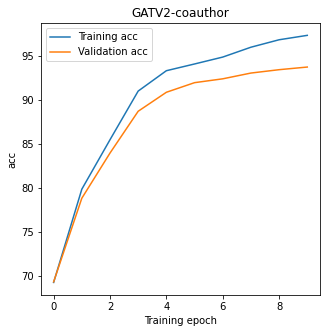

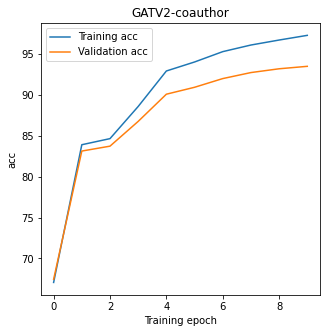

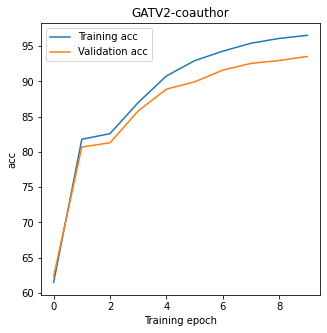

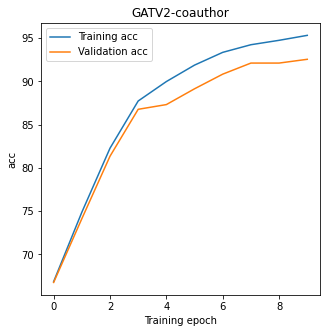

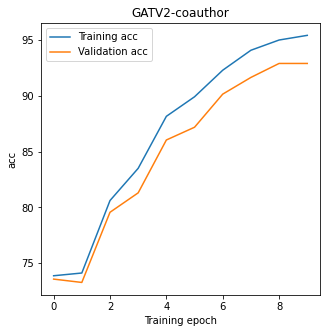

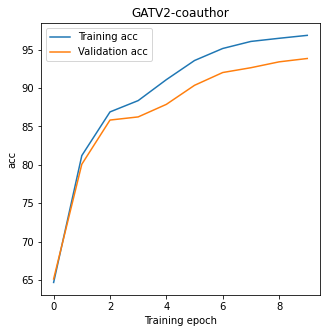

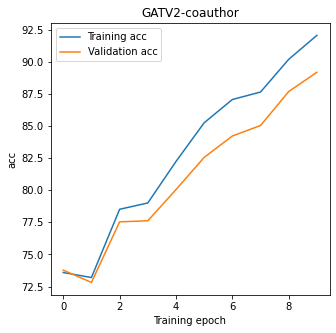

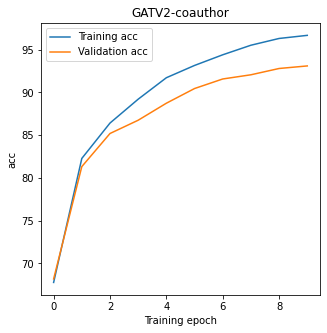

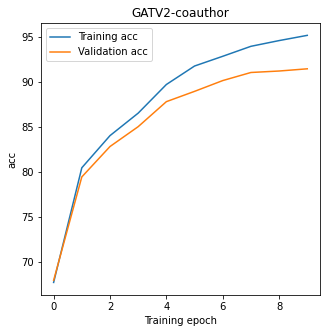

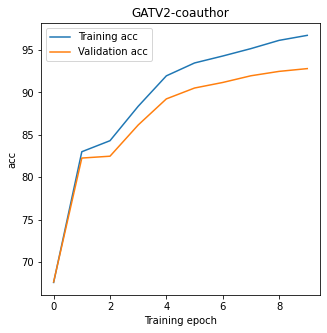

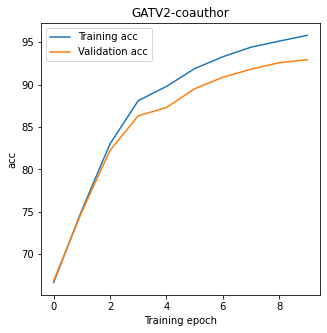

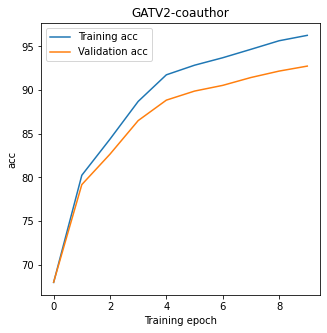

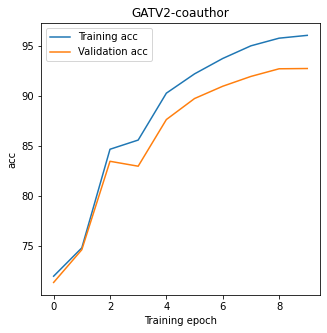

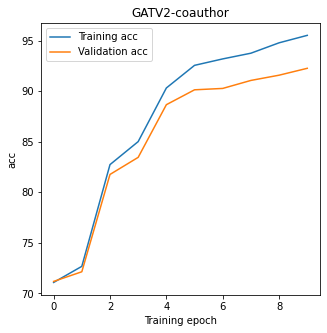

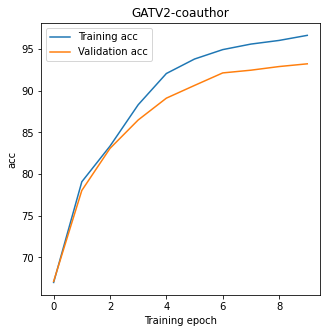

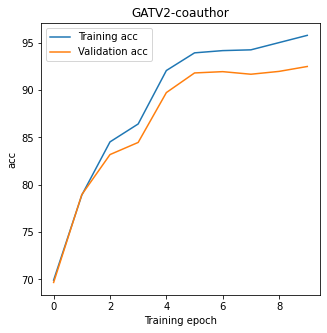

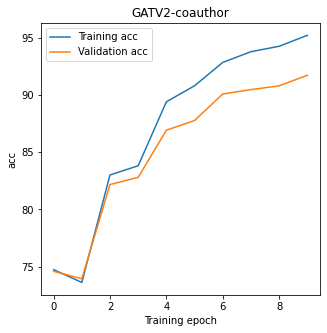

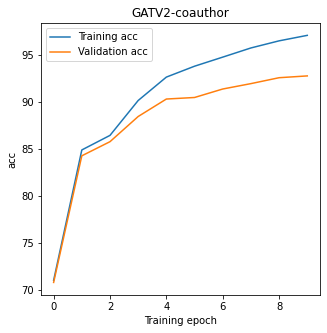

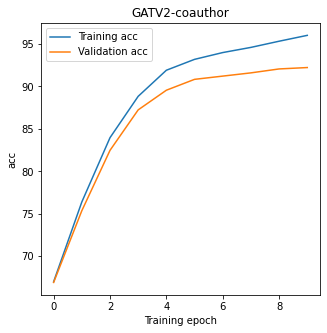

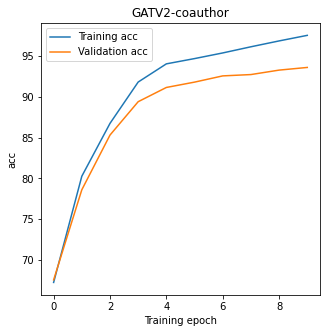

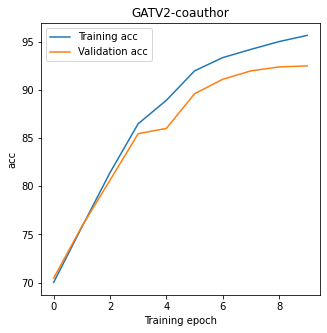

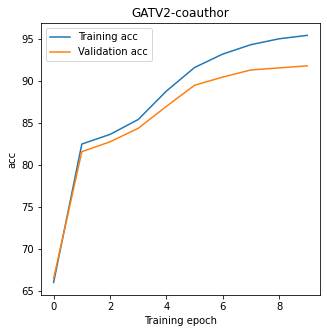

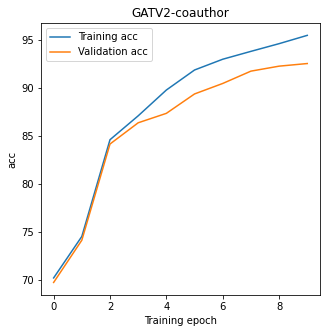

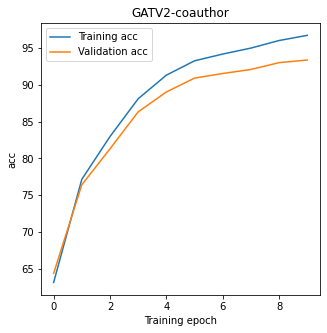

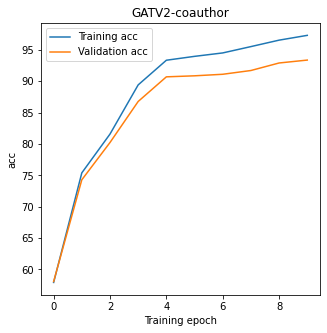

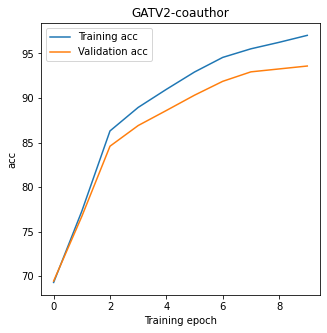

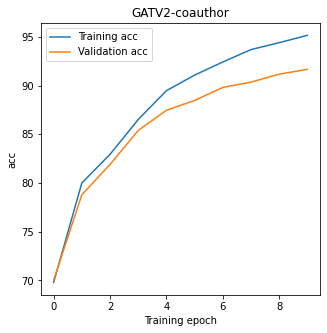

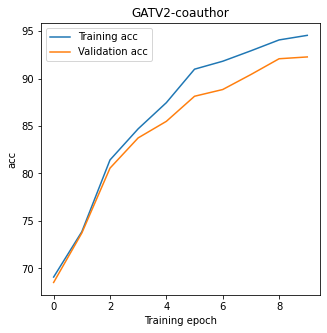

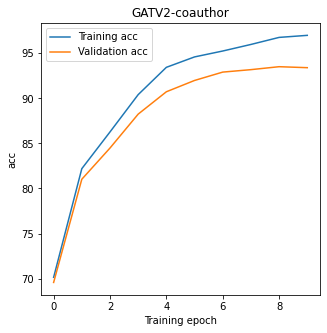

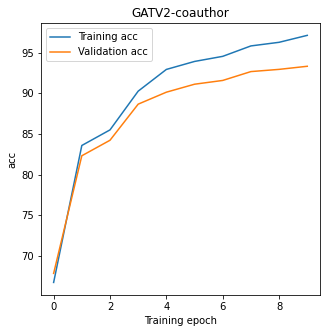

In [ ]:
# General training loop for all models except GraphSAGE, using the whole graph in training instead of using subgraph batching
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for seed in seeds:
  set_seeds(seed)
  # Create the model
  model = GATModelWrapper(in_channels = node_features.shape[-1], hidden_channels = HIDDEN_DIM, num_layers=1, out_channels=num_classes, v2=True)
  model = model.to(device)

  # Run training loop
  print("TRAINING WITH SEED: ", str(seed))
  train_stats_cora = train_eval_loop_gnn(model, edge_indices, node_features, train_y, train_mask, 
                                            node_features, valid_y, valid_mask, node_features, test_y, test_mask, num_classes, seed, filename+"/"+filename, device, is_cora)
  # Print out graphs if not using GPU
  if device == torch.device('cpu'):
    plot_stats(train_stats_cora, name=filename)

In [ ]:
# Training loop for GraphSAGE which using subgraph batches instead of the entire graph
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for seed in seeds:
  set_seeds(seed)
  # Original paper uses neighbourhood sizes  S1 = 25 and S2 = 10 so this is what we use
  train_loader = NeighborLoader(neighbour_dataset, num_neighbors = [25, 10], batch_size=1024, input_nodes=train_mask)

  # Create the model
  model = GraphSAGEModelWrapper(in_channels = node_features.shape[-1], hidden_channels = HIDDEN_DIM, num_layers=1, out_channels=num_classes)
  model = model.to(device)

  # Run training loop
  print("TRAINING WITH SEED: ", str(seed))
  train_stats_cora = train_eval_loop_gnn(model, edge_indices, node_features, train_y, train_mask, 
                                            node_features, valid_y, valid_mask, node_features, test_y, test_mask, num_classes, seed, filename+"/"+filename, device, is_cora, subgraph_batches=train_loader)
  # Print out graphs if not using GPU
  if device == torch.device('cpu'):
    plot_stats(train_stats_cora, name=filename)

SETTING SEEDS TO:  4193977854
TRAINING WITH SEED:  4193977854
Epoch 0 with train loss: 0.639 train accuracy: 95.870 validation accuracy: 93.539
Per class train accuracy:  tensor([0.9505, 0.8087, 0.9553, 0.9650, 0.9258, 0.9605, 0.8964, 0.9495, 0.9075,
        0.9857, 0.9642, 0.9795, 0.9960, 0.9863, 0.9695], device='cuda:0')
Per class val accuracy:  tensor([0.9225, 0.6957, 0.9439, 0.9302, 0.8889, 0.9180, 0.8514, 0.9297, 0.8387,
        0.9583, 0.9412, 0.9631, 0.9643, 0.9855, 0.9714], device='cuda:0')
Epoch 9 with train loss: 0.040 train accuracy: 98.563 validation accuracy: 93.157
Per class train accuracy:  tensor([0.9976, 1.0000, 0.9992, 1.0000, 1.0000, 1.0000, 0.9955, 0.9964, 0.9957,
        1.0000, 1.0000, 0.8778, 1.0000, 0.9996, 0.9981], device='cuda:0')
Per class val accuracy:  tensor([0.9507, 0.8043, 0.9244, 0.9070, 0.9247, 0.9909, 0.7973, 0.8811, 0.8968,
        0.9583, 0.9758, 0.8133, 0.9286, 0.9807, 0.9829], device='cuda:0')
Our final test accuracy for the GNN is: 93.083
Final p

# TESTING LOADING

In [ ]:
final_results = load_final_results(filename)
for r in final_results:
  print(r)

In [ ]:
training_stats_1, embedding = load_training_info(filename+"_1")
plot_stats(training_stats_1, name="Testing")
print(embedding)
print(node_features)

In [ ]:
# Loading stored model weights
model = GATModelWrapper(in_channels = node_features.shape[-1], hidden_channels = node_features.shape[-1], num_layers=1, out_channels=num_classes, v2=True)
model.load_state_dict(torch.load(file_path+filename+"/"+"GATV2_1_model.pt"))
model.eval()

- Plot graph with average training stats
- Save node embeddings for each run
- Save training stats for each run
- Save test accuracy for each run


# Node2Vec Cora

In [ ]:
def save_training_info(training_stats: dict, filename: str):
  # write training data info to a file
  with open(file_path + filename + ".pkl", 'wb') as fp:
    pickle.dump(training_stats, fp)
    print('Training stats saved successfully to file: ' + filename)
  # write node embedding to a file
  #torch.save(node_embedding, file_path + filename + ".pt")
  #print('Node embedding saved successfully to file: ' + filename)


In [ ]:
# Code taken from L45 practical notebook
def train_n2v_cora(X, edge_indices, y, mask, model, optimiser, loader):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_n2v_cora(X, edge_indices, y, mask, model, num_classes, loader):
    model.eval()
    z = model()
    acc = model.test(z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      z[cora_data.val_mask], cora_data.y[cora_data.val_mask],
                      max_iter=150)
    #y_out = z[cora_data.train_mask]
    y_hat = z[cora_data.val_mask].to(device)
    y = cora_data.y[cora_data.val_mask].to(device)
    
    #model.eval()
    #y_out, node_embeddings = model(X, edge_indices)
    #y_hat = y_out[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)

    # calculate per class accuracy
    values, counts = torch.unique(y_hat[y_hat == y.data], return_counts=True)
    per_class_counts = torch.zeros(num_classes)
    # allocate the number of counts per class
    for i, x in enumerate(values):
      per_class_counts[x] = counts[i]
    per_class_counts = per_class_counts.to(device)
    # find total number of data points per class in the split
    total_per_class = torch.bincount(y.data).to(device)
    per_class_accuracy = torch.div(per_class_counts, total_per_class)

    return accuracy, per_class_accuracy
    
# Training loop
def train_eval_loop_n2v_cora(model, edge_indices, train_x, train_y, train_mask, valid_x, valid_y, valid_mask, 
                             test_x, test_y, test_mask, num_classes, seed, filename, loader):
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_n2v_cora(train_x, edge_indices, train_y, train_mask, model, optimiser, loader)
        train_acc, train_class_acc = evaluate_n2v_cora(train_x, edge_indices, train_y, train_mask, model, num_classes, loader)
        valid_acc, valid_class_acc = evaluate_n2v_cora(valid_x, edge_indices, valid_y, valid_mask, model, num_classes, loader)
        if epoch % 10 == 0 or epoch == (NUM_EPOCHS-1):
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f} validation accuracy: {valid_acc:.3f}")
            #print("Per class train accuracy: ", train_class_acc)
            #print("Per class val accuracy: ", valid_class_acc)
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)

    # Lets look at our final test performance
    # Only need to get the node embeddings once, take from the training evaluation call
    test_acc, test_class_acc = evaluate_n2v_cora(test_x, edge_indices, test_y, test_mask, model, num_classes, loader)
    print(f"Our final test accuracy for the GNN is: {test_acc:.3f}")
    print("Final per class accuracy on test set: ", test_class_acc)

    # Save training stats if on final iteration of the run
    save_training_info(training_stats, filename+"_"+str(seed))
    # Save final results
    final_results_list = [seed, test_acc, test_class_acc, train_class_acc, valid_class_acc]
    save_final_results(final_results_list, filename)
    # Save final model weights incase we want to do further inference later
    torch.save(model.state_dict(), file_path+filename+"_" + str(seed) + "_model.pt")
    return training_stats

In [ ]:
from torch_geometric.nn import Node2Vec

# Get the edge indices and node features for our model
edge_indices = cora_data.edge_index
node_features = cora_data.x

# Get masks and training labels for each split
train_mask = cora_data.train_mask
train_y = cora_data.y[train_mask]
valid_mask = cora_data.val_mask
valid_y = cora_data.y[valid_mask]
test_mask = cora_data.test_mask
test_y = cora_data.y[test_mask]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_classes = 7
# CHANGE: To name of model being tested
filename = "Node2Vec"
# use 30 seeds which have been randomly generated using seed_list = [np.random.randint(4294967296 - 1) for i in range(30)]
seeds = [4193977854, 1863727779, 170173784, 2342954646, 116846604, 2105922959, 2739899259, 1024258131, 806299656, 880019963, 1818027900, 2135956485, 3710910636, 1517964140, 4083009686, 2455059856, 400225693, 89475662, 361232447, 3647665043, 1221215631, 2036056847, 1860537279, 516507873, 3692371949, 3300171104, 2794978777, 3303475786, 2952735006, 572297925]

# create folder for saving all model info into if it does not exist already
if not os.path.exists(file_path+filename+"/"):
  os.mkdir(file_path+filename+"/")

for seed in seeds:
  set_seeds(seed)
  # Create the model
  #model = GATModelWrapper(in_channels = node_features.shape[-1], hidden_channels = node_features.shape[-1], num_layers=1, out_channels=num_classes, v2=True)
  model = Node2Vec(cora_data.edge_index.to(device), embedding_dim=128, walk_length=20,
                     context_size=10, walks_per_node=10,
                     num_negative_samples=1, p=1, q=1, sparse=True).to(device)
  loader = model.loader(batch_size=128, shuffle=True,
                          num_workers=0)
  optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

  #train_stats_cora = train_eval_loop_gnn_cora(model, edge_indices, node_features, train_y, train_mask, 
                                            #node_features, valid_y, valid_mask, node_features, test_y, test_mask, num_classes, seed, filename+"/"+filename, loader)

  def train():
      model.train()
      total_loss = 0
      for pos_rw, neg_rw in loader:
          optimizer.zero_grad()
          loss = model.loss(pos_rw.to(device), neg_rw.to(device))
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          #print(loss.data)
      #epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
      return total_loss / len(loader)

  @torch.no_grad()
  def test():
    model.eval()
    z = model()
    acc_train = model.test(z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      max_iter=150)
    acc_val = model.test(z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      z[cora_data.val_mask], cora_data.y[cora_data.val_mask],
                      max_iter=150)
    acc_test = model.test(z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      z[cora_data.test_mask], cora_data.y[cora_data.test_mask],
                      max_iter=150)
    y_train = cora_data.y[cora_data.train_mask].to(device)
    y_hat_train = z[cora_data.train_mask].to(device)
    y_val = cora_data.y[cora_data.val_mask].to(device)
    y_hat_val = z[cora_data.val_mask].to(device)
    y_test = cora_data.y[cora_data.test_mask].to(device)
    y_hat_test = z[cora_data.test_mask].to(device)

    loss_train = F.cross_entropy(y_hat_train, y_train)
    loss_val = F.cross_entropy(y_hat_val, y_val)
    loss_test = F.cross_entropy(y_hat_test, y_test)

    return acc_train, acc_val, acc_test, loss_train, loss_val, loss_test

  training_stats = None
  for epoch in range(1, 40):
    loss = train()
    acc_train, acc_val, acc_test, loss_train, loss_val, loss_test = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc_train: {acc_train:.4f}, Acc_val: {acc_val:.4f}, Acc_test: {acc_test:.4f}')
    epoch_stats = {'train_acc': acc_train, 'val_acc': acc_val, 'test_acc': acc_test, 'epoch':epoch}
    training_stats = update_stats(training_stats, epoch_stats)
  
  # Save training stats if on final iteration of the run
  save_training_info(training_stats, filename+"_"+str(seed))
  # Save final results
  #final_results_list = [seed, acc_test, test_class_acc, train_class_acc, valid_class_acc]
  #save_final_results(final_results_list, filename)
  # Save final model weights incase we want to do further inference later
  torch.save(model.state_dict(), file_path+filename+"_" + str(seed) + "_model.pt")
  # Run training loop
  #print("TRAINING WITH SEED: ", str(seed))
  #train_stats_cora = train_eval_loop_gnn_cora(model, edge_indices, node_features, train_y, train_mask, 
  #                                          node_features, valid_y, valid_mask, node_features, test_y, test_mask, num_classes, seed, filename+"/"+filename)
  #plot_stats(train_stats_cora, name=filename+"_Cora")

In [ ]:
from torch_geometric.nn import Node2Vec

# Get the edge indices and node features for our model
edge_indices = cora_data.edge_index
node_features = cora_data.x

# Get masks and training labels for each split
train_mask = cora_data.train_mask
train_y = cora_data.y[train_mask]
valid_mask = cora_data.val_mask
valid_y = cora_data.y[valid_mask]
test_mask = cora_data.test_mask
test_y = cora_data.y[test_mask]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_classes = 7
# CHANGE: To name of model being tested
filename = "Node2Vec"
# use 30 seeds which have been randomly generated using seed_list = [np.random.randint(4294967296 - 1) for i in range(30)]
seeds = [4193977854, 1863727779, 170173784, 2342954646, 116846604, 2105922959, 2739899259, 1024258131, 806299656, 880019963, 1818027900, 2135956485, 3710910636, 1517964140, 4083009686, 2455059856, 400225693, 89475662, 361232447, 3647665043, 1221215631, 2036056847, 1860537279, 516507873, 3692371949, 3300171104, 2794978777, 3303475786, 2952735006, 572297925]

# create folder for saving all model info into if it does not exist already
if not os.path.exists(file_path+filename+"/"):
  os.mkdir(file_path+filename+"/")

for seed in seeds:
  set_seeds(seed)
  # Create the model
  #model = GATModelWrapper(in_channels = node_features.shape[-1], hidden_channels = node_features.shape[-1], num_layers=1, out_channels=num_classes, v2=True)
  model = Node2Vec(cora_data.edge_index.to(device), embedding_dim=128, walk_length=20,
                     context_size=10, walks_per_node=10,
                     num_negative_samples=1, p=1, q=1, sparse=True).to(device)
  loader = model.loader(batch_size=128, shuffle=True,
                          num_workers=0)
  optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

  #train_stats_cora = train_eval_loop_gnn_cora(model, edge_indices, node_features, train_y, train_mask, 
                                            #node_features, valid_y, valid_mask, node_features, test_y, test_mask, num_classes, seed, filename+"/"+filename, loader)

  def train():
      model.train()
      total_loss = 0
      for pos_rw, neg_rw in loader:
          optimizer.zero_grad()
          loss = model.loss(pos_rw.to(device), neg_rw.to(device))
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          #print(loss.data)
      #epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
      return total_loss / len(loader)

  @torch.no_grad()
  def test():
    model.eval()
    z = model()
    print(z[cora_data.train_mask].shape, cora_data.y[cora_data.train_mask].shape,
                      z[cora_data.train_mask].shape, cora_data.y[cora_data.train_mask].shape)
    acc_train = model.test(z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      max_iter=150)
    acc_val = model.test(z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      z[cora_data.val_mask], cora_data.y[cora_data.val_mask],
                      max_iter=150)
    acc_test = model.test(z[cora_data.train_mask], cora_data.y[cora_data.train_mask],
                      z[cora_data.test_mask], cora_data.y[cora_data.test_mask],
                      max_iter=150)
    
    y_train = cora_data.y[cora_data.train_mask].to(device)
    y_hat_train = z[cora_data.train_mask].to(device)
    y_val = cora_data.y[cora_data.val_mask].to(device)
    y_hat_val = z[cora_data.val_mask].to(device)
    y_test = cora_data.y[cora_data.test_mask].to(device)
    y_hat_test = z[cora_data.test_mask].to(device)
    print(y_hat_train.shape, y_train.shape)

    loss_train = F.cross_entropy(y_hat_train, y_train)
    loss_val = F.cross_entropy(y_hat_val, y_val)
    loss_test = F.cross_entropy(y_hat_test, y_test)

    return acc_train, acc_val, acc_test, loss_train, loss_val, loss_test

  training_stats = None
  for epoch in range(1, 40):
    loss = train()
    acc_train, acc_val, acc_test, loss_train, loss_val, loss_test = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc_train: {acc_train:.4f}, Acc_val: {acc_val:.4f}, Acc_test: {acc_test:.4f}')
    epoch_stats = {'train_acc': acc_train, 'val_acc': acc_val, 'test_acc': acc_test, 'epoch':epoch}
    training_stats = update_stats(training_stats, epoch_stats)
  
  # Save training stats if on final iteration of the run
  save_training_info(training_stats, filename+"_"+str(seed))
  # Save final results
  #final_results_list = [seed, acc_test, test_class_acc, train_class_acc, valid_class_acc]
  #save_final_results(final_results_list, filename)
  # Save final model weights incase we want to do further inference later
  torch.save(model.state_dict(), file_path+filename+"_" + str(seed) + "_model.pt")
  # Run training loop
  #print("TRAINING WITH SEED: ", str(seed))
  #train_stats_cora = train_eval_loop_gnn_cora(model, edge_indices, node_features, train_y, train_mask, 
  #                                          node_features, valid_y, valid_mask, node_features, test_y, test_mask, num_classes, seed, filename+"/"+filename)
  #plot_stats(train_stats_cora, name=filename+"_Cora")

# FastRP (attempt)

In [ ]:
import csv
import itertools
import math
import matplotlib
import time
import logging
import sys
import os
import random
import warnings
import gensim
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from pathlib import Path
from sklearn import random_projection
from sklearn.preprocessing import normalize, scale, MultiLabelBinarizer
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, spdiags

# projection method: choose from Gaussian and Sparse
# input matrix: choose from adjacency and transition matrix
# alpha adjusts the weighting of nodes according to their degree
def fastrp_projection(A, q=3, dim=128, projection_method='gaussian', input_matrix='adj', alpha=None):
    assert input_matrix == 'adj' or input_matrix == 'trans'
    assert projection_method == 'gaussian' or projection_method == 'sparse'
    
    if input_matrix == 'adj':
        M = A
    else:
        N = A.shape[0]
        normalizer = spdiags(np.squeeze(1.0 / csc_matrix.sum(A, axis=1) ), 0, N, N)
        M = normalizer @ A
    # Gaussian projection matrix
    if projection_method == 'gaussian':
        transformer = random_projection.GaussianRandomProjection(n_components=dim, random_state=42)
    # Sparse projection matrix
    else:
        transformer = random_projection.SparseRandomProjection(n_components=dim, random_state=42)
    Y = transformer.fit(M)
    # Random projection for A
    if alpha is not None:
        Y.components_ = Y.components_ @ spdiags( \
                        np.squeeze(np.power(csc_matrix.sum(A, axis=1), alpha)), 0, N, N)
    cur_U = transformer.transform(M)
    U_list = [cur_U]
    
    for i in range(2, q + 1):
        cur_U = M @ cur_U
        U_list.append(cur_U)
    return U_list

# When weights is None, concatenate instead of linearly combines the embeddings from different powers of A
def fastrp_merge(U_list, weights, normalization=False):
    dense_U_list = [_U.todense() for _U in U_list] if type(U_list[0]) == csc_matrix else U_list
    _U_list = [normalize(_U, norm='l2', axis=1) for _U in dense_U_list] if normalization else dense_U_list

    if weights is None:
        return np.concatenate(_U_list, axis=1)
    U = np.zeros_like(_U_list[0])
    for cur_U, weight in zip(_U_list, weights):
        U += cur_U * weight
    # U = scale(U.todense())
    # U = normalize(U.todense(), norm='l2', axis=1)
    return scale(U.todense()) if type(U) == csr_matrix else scale(U)

# A is always the adjacency matrix
# the choice between adj matrix and trans matrix is decided in the conf
def fastrp_wrapper(A, conf):
    U_list = fastrp_projection(A,
                               q=len(conf['weights']),
                               dim=conf['dim'],
                               projection_method=conf['projection_method'],
                               input_matrix=conf['input_matrix'],
                               alpha=conf['alpha'],
    )
    U = fastrp_merge(U_list, conf['weights'], conf['normalization'])
    return U

def get_emb_filename(prefix, conf):
    return prefix + '-dim=' + str(conf['dim']) + ',projection_method=' + conf['projection_method'] \
        + ',input_matrix=' + conf['input_matrix'] + ',normalization=' + str(conf['normalization']) \
        + ',weights=' + (','.join(map(str, conf['weights'])) if conf['weights'] is not None else 'None') \
        + ',alpha=' + (str(conf['alpha']) if 'alpha' in conf else '') \
        + ',C=' + (str(conf['C']) if 'alpha' in conf else '1.0') \
        + '.mat'


In [ ]:
fastrp_projection()

#  OGBN-archiv dataset

In [ ]:
from torch_geometric.nn import Node2Vec

# Get the edge indices and node features for our model
edge_indices = arxiv_data.edge_index
node_features = arxiv_data.x

# Get masks and training labels for each split
train_mask = train_idx
train_y = arxiv_data.y[train_mask]
valid_mask = valid_idx
valid_y = arxiv_data.y[valid_mask]
test_mask = test_idx
test_y = arxiv_data.y[test_mask]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_classes = 40
# CHANGE: To name of model being tested
filename = "Node2Vec_arxiv"
# use 30 seeds which have been randomly generated using seed_list = [np.random.randint(4294967296 - 1) for i in range(30)]
seeds = [4193977854, 1863727779, 170173784, 2342954646, 116846604, 2105922959, 2739899259, 1024258131, 806299656, 880019963]

# create folder for saving all model info into if it does not exist already
if not os.path.exists(file_path+filename+"/"):
  os.mkdir(file_path+filename+"/")

for seed in seeds:
  set_seeds(seed)
  # Create the model
  #model = GATModelWrapper(in_channels = node_features.shape[-1], hidden_channels = node_features.shape[-1], num_layers=1, out_channels=num_classes, v2=True)
  model = Node2Vec(arxiv_data.edge_index.to(device), embedding_dim=128, walk_length=20,
                     context_size=10, walks_per_node=10,
                     num_negative_samples=1, p=1, q=1, sparse=True).to(device)
  loader = model.loader(batch_size=128, shuffle=True,
                          num_workers=0)
  optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

  def train():
      model.train()
      total_loss = 0
      for pos_rw, neg_rw in loader:
          optimizer.zero_grad()
          loss = model.loss(pos_rw.to(device), neg_rw.to(device))
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          #print(loss.data)
      #epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
      return total_loss / len(loader)

  @torch.no_grad()
  def test():
    model.eval()
    z = model()
    print(z[train_mask].shape, arxiv_data.y[train_mask].shape,
                      z[train_mask].shape, arxiv_data.y[train_mask].shape)
    acc_train = model.test(z[train_mask], arxiv_data.y[train_mask],
                      z[train_mask], arxiv_data.y[train_mask],
                      max_iter=150)
    acc_val = model.test(z[train_mask], arxiv_data.y[train_mask],
                      z[valid_mask], arxiv_data.y[valid_mask],
                      max_iter=150)
    acc_test = model.test(z[train_mask], arxiv_data.y[train_mask],
                      z[test_mask], arxiv_data.y[test_mask],
                      max_iter=150)
    y_train = arxiv_data.y[train_mask].to(device).squeeze()
    y_hat_train = z[train_mask].to(device)
    print(y_hat_train.shape, y_train.shape)
    y_val = arxiv_data.y[valid_mask].to(device).squeeze()
    y_hat_val = z[valid_mask].to(device)
    print(y_hat_val.shape, y_val.shape)
    y_test = arxiv_data.y[test_mask].to(device).squeeze()
    y_hat_test = z[test_mask].to(device)
    print(y_hat_test.shape, y_test.shape)

    loss_train = F.cross_entropy(y_hat_train, y_train)
    loss_val = F.cross_entropy(y_hat_val, y_val)
    loss_test = F.cross_entropy(y_hat_test, y_test)

    return acc_train, acc_val, acc_test, loss_train, loss_val, loss_test

  training_stats = None
  for epoch in range(1, 40):
    loss = train()
    acc_train, acc_val, acc_test, loss_train, loss_val, loss_test = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc_train: {acc_train:.4f}, Acc_val: {acc_val:.4f}, Acc_test: {acc_test:.4f}')
    epoch_stats = {'train_acc': acc_train, 'val_acc': acc_val, 'test_acc': acc_test, 'epoch':epoch}
    training_stats = update_stats(training_stats, epoch_stats)
  
  # Save training stats if on final iteration of the run
  save_training_info(training_stats, filename+"_"+str(seed))
  # Save final results
  #final_results_list = [seed, acc_test, test_class_acc, train_class_acc, valid_class_acc]
  #save_final_results(final_results_list, filename)
  # Save final model weights incase we want to do further inference later
  torch.save(model.state_dict(), file_path+filename+"_" + str(seed) + "_model.pt")

In [ ]:
#print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc_train: {acc_train:.4f}, Acc_val: {acc_val:.4f}, Acc_test: {acc_test:.4f}')

<class 'builtin_function_or_method'>


# Similarity tests

https://github.com/SGDE2020/embedding_stability/blob/master/similarity_tests/similarity_tests.py